In [1]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2 

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham
import bobsegutils as bsu

from shapely import geometry
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from descartes.patch import PolygonPatch

from scipy.interpolate import griddata

from scipy.stats.stats import pearsonr
from scipy.stats.stats import kendalltau

Populating the interactive namespace from numpy and matplotlib


/Users/prakash/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading and preparing data

```stack``` is the original stack as it is loaded from file<br>
```segchannel``` is the membrane channel only (needs to be taken out of loaded stack)<br>
```flowchannel``` is the myosin channel only<br>
```segchannel_smooth``` is the ```segchannel``` after gaussian smoothing<br>
(note: the less the better for the gradientimage)<br>
```gradientimage``` should be used for segmentation if some of the cell boundary (membrane) is barely visible<br>

In [2]:
filename = '/Users/prakash/anaconda/envs/BobSegExtra/Data/ProjectGoldstein/4MyosinMembraneWholeEmbryo.tif'
# filename = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/MAX_mNG-mSc_04_MEDIUM_UNCOUPLED.tif'
# filename = '/Users/jug/Repositories/GIT/BobSeg/data/ProjectGoldstein/MAX_mNG-mSc_05_MEDIUM_COUPLED.tif'

stack = imread(filename)
segchannel = stack[:,0,:,:]
flowchannel = stack[:,1,:,:]

sigma = [0.,2,2]
segchannel_smooth = gaussian(segchannel,sigma)

gx = np.gradient(segchannel_smooth, 25, axis=2)
gy = np.gradient(segchannel_smooth, 25, axis=1)
gx = np.abs(gx)
gy = np.abs(gy)
gradientimage = gx+gy                  # add x and y gradients
gradientimage /= np.max(gradientimage) # normalizes such that largest value is 1.0
gradientimage **= .5                   # emphasizes smaller gradient values
gradientimage = gaussian(gradientimage,sigma)

T = len(segchannel)  # number of time-points

print('Shape of stack:', stack.shape)
print('Shape of flow channel:', flowchannel.shape)

Shape of stack: (75, 2, 356, 610)
Shape of flow channel: (75, 356, 610)


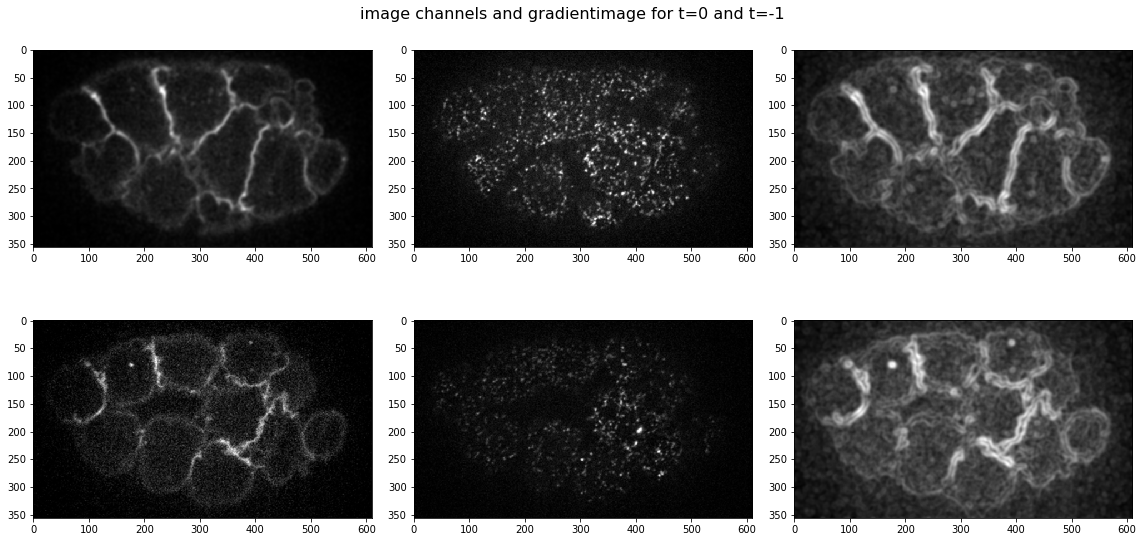

In [3]:
pylab.rcParams['figure.figsize'] = (16, 8)
fig = plt.figure()
fig.suptitle('image channels and gradientimage for t=0 and t=-1', fontsize=16)
ax = fig.add_subplot(231)
ax.imshow(segchannel_smooth[0], plt.get_cmap('gray'))
ax = fig.add_subplot(232)
ax.imshow(flowchannel[0], plt.get_cmap('gray'))
ax = fig.add_subplot(233)
ax.imshow(gradientimage[0], plt.get_cmap('gray'))
ax = fig.add_subplot(234)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(235)
ax.imshow(flowchannel[-1], plt.get_cmap('gray'))
ax = fig.add_subplot(236)
ax.imshow(gradientimage[-1], plt.get_cmap('gray'))
fig.tight_layout()

# Cell segmentation

In [4]:
# defining min and max radius for cell segmentation
max_rs = ((segchannel[0].shape[1] / 5),
          (segchannel[0].shape[1] / 5))

min_rs = (10,10)
print (min_rs, max_rs)

(10, 10) (122.0, 122.0)


In [5]:
data = Data3d( gradientimage, pixelsize=(1.,1.), silent=False )
data.set_seg_params(num_columns=72,K=100,max_delta_k=4)
objects = []

In [6]:
cell_Ea = data.init_object("Ea")
objects.append(cell_Ea)
data.add_object_at( cell_Ea, min_rs, max_rs, frame=0, seed=(330,200), segment_it=True )
moving_center_Ea = data.track(cell_Ea, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ea" in frame 0 with seed coordinates [ 330.  200.]
      Optimum energy:  31.051660117351688
      Nodes in/out:  3665 3535
      Area:  13839.5
Added appearance for "Ea" in frame 1 with seed coordinates [ 330.  200.]
      Optimum energy:  30.382149104663647
      Nodes in/out:  3533 3667
      Area:  13134.5
    Updated center to [ 338.25        200.95833333]
Added appearance for "Ea" in frame 2 with seed coordinates [ 338.  201.]
      Optimum energy:  28.700247302584074
      Nodes in/out:  3641 3559
      Area:  13582.0
    Updated center to [ 343.26388889  198.875     ]
Added appearance for "Ea" in frame 3 with seed coordinates [ 343.  199.]
      Optimum energy:  27.943837825588645
      Nodes in/out:  3732 3468
      Area:  13942.5
    Updated center to [ 343.98611111  197.125     ]
Added appearance for "Ea" in frame 4 with seed coordinates [ 344.  197.]
      Optimum energy:  29.501224963483743
      Nodes in/out:  3625 3575
      Area:  13246.0
    Updat

      Area:  13143.5
    Updated center to [ 358.47222222  164.20833333]
Added appearance for "Ea" in frame 42 with seed coordinates [ 358.  164.]
      Optimum energy:  28.656593515491885
      Nodes in/out:  3692 3508
      Area:  13460.5
    Updated center to [ 358.75        164.36111111]
Added appearance for "Ea" in frame 43 with seed coordinates [ 359.  164.]
      Optimum energy:  28.223796656632803
      Nodes in/out:  3692 3508
      Area:  13508.5
    Updated center to [ 358.73611111  164.51388889]
Added appearance for "Ea" in frame 44 with seed coordinates [ 359.  165.]
      Optimum energy:  26.777535411913302
      Nodes in/out:  3568 3632
      Area:  12663.5
    Updated center to [ 356.66666667  164.84722222]
Added appearance for "Ea" in frame 45 with seed coordinates [ 357.  165.]
      Optimum energy:  25.988980428364016
      Nodes in/out:  3484 3716
      Area:  12155.5
    Updated center to [ 355.68055556  164.13888889]
Added appearance for "Ea" in frame 46 with seed

In [7]:
cell_Ep = data.init_object("Ep")
objects.append(cell_Ep)
data.add_object_at( cell_Ep, min_rs, max_rs, frame=0, seed=(460,250), segment_it=True )
moving_center_Ep = data.track(cell_Ep, seed_frame=0, target_frames=range(1,len(data.images)), recenter_iterations=1)

Added appearance for "Ep" in frame 0 with seed coordinates [ 460.  250.]
      Optimum energy:  24.74844299395056
      Nodes in/out:  3609 3591
      Area:  14276.0
Added appearance for "Ep" in frame 1 with seed coordinates [ 460.  250.]
      Optimum energy:  23.089913770930554
      Nodes in/out:  3629 3571
      Area:  14421.0
    Updated center to [ 447.40277778  242.65277778]
Added appearance for "Ep" in frame 2 with seed coordinates [ 447.  243.]
      Optimum energy:  25.505052996415248
      Nodes in/out:  3876 3324
      Area:  15085.5
    Updated center to [ 443.73611111  237.51388889]
Added appearance for "Ep" in frame 3 with seed coordinates [ 444.  238.]
      Optimum energy:  24.25862428046818
      Nodes in/out:  3781 3419
      Area:  14548.5
    Updated center to [ 441.54166667  233.125     ]
Added appearance for "Ep" in frame 4 with seed coordinates [ 442.  233.]
      Optimum energy:  23.069398272852165
      Nodes in/out:  3794 3406
      Area:  14435.5
    Updated

      Nodes in/out:  3369 3831
      Area:  11520.5
    Updated center to [ 444.56944444  226.93055556]
Added appearance for "Ep" in frame 44 with seed coordinates [ 445.  227.]
      Optimum energy:  23.857056184399895
      Nodes in/out:  3462 3738
      Area:  12128.0
    Updated center to [ 445.33333333  226.27777778]
Added appearance for "Ep" in frame 45 with seed coordinates [ 445.  226.]
      Optimum energy:  24.035481350319582
      Nodes in/out:  3327 3873
      Area:  11238.5
    Updated center to [ 443.52777778  225.79166667]
Added appearance for "Ep" in frame 46 with seed coordinates [ 444.  226.]
      Optimum energy:  21.96620142928405
      Nodes in/out:  3409 3791
      Area:  11746.5
    Updated center to [ 443.83333333  224.73611111]
Added appearance for "Ep" in frame 47 with seed coordinates [ 444.  225.]
      Optimum energy:  23.12698564997995
      Nodes in/out:  3462 3738
      Area:  12094.5
    Updated center to [ 443.08333333  225.69444444]
Added appearance f

In [8]:
surface_coords_Ea = data.segment2dt( cell_Ea, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  2112.2379972619256
      Area:  13491.5
Results for frame 1:
      Optimum energy:  2112.2379972619256
      Area:  13550.0
Results for frame 2:
      Optimum energy:  2112.2379972619256
      Area:  13566.5
Results for frame 3:
      Optimum energy:  2112.2379972619256
      Area:  13921.0
Results for frame 4:
      Optimum energy:  2112.2379972619256
      Area:  14202.0
Results for frame 5:
      Optimum energy:  2112.2379972619256
      Area:  14268.5
Results for frame 6:
      Optimum energy:  2112.2379972619256
      Area:  14312.0
Results for frame 7:
      Optimum energy:  2112.2379972619256
      Area:  14359.0
Results for frame 8:
      Optimum energy:  2112.2379972619256
      Area:  14120.0
Results for frame 9:
      Optimum energy:  2112.2379972619256
      Area:  13664.0
Results for frame 10:
      Optimum energy:  2112.2379972619256
      Area:  13488.0
Results for frame 11:
      Optimum energy:  2112.2379972619256
      Area:

In [9]:
surface_coords_Ep = data.segment2dt( cell_Ep, max_radial_delta=2 )

Results for frame 0:
      Optimum energy:  1849.3357315923265
      Area:  14810.0
Results for frame 1:
      Optimum energy:  1849.3357315923265
      Area:  14719.0
Results for frame 2:
      Optimum energy:  1849.3357315923265
      Area:  14732.5
Results for frame 3:
      Optimum energy:  1849.3357315923265
      Area:  14643.5
Results for frame 4:
      Optimum energy:  1849.3357315923265
      Area:  14558.0
Results for frame 5:
      Optimum energy:  1849.3357315923265
      Area:  14536.5
Results for frame 6:
      Optimum energy:  1849.3357315923265
      Area:  14575.0
Results for frame 7:
      Optimum energy:  1849.3357315923265
      Area:  14514.0
Results for frame 8:
      Optimum energy:  1849.3357315923265
      Area:  14483.5
Results for frame 9:
      Optimum energy:  1849.3357315923265
      Area:  14482.5
Results for frame 10:
      Optimum energy:  1849.3357315923265
      Area:  14404.0
Results for frame 11:
      Optimum energy:  1849.3357315923265
      Area:

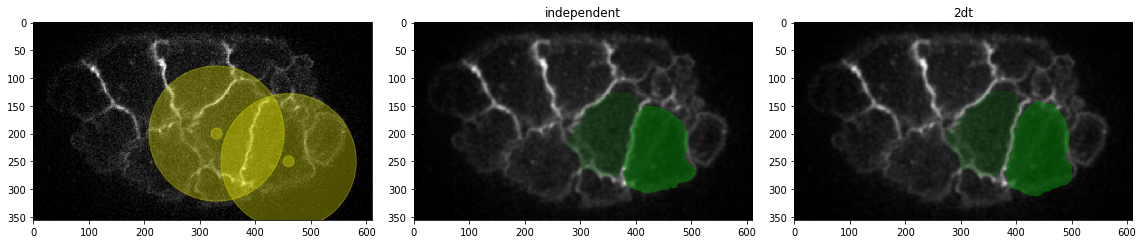

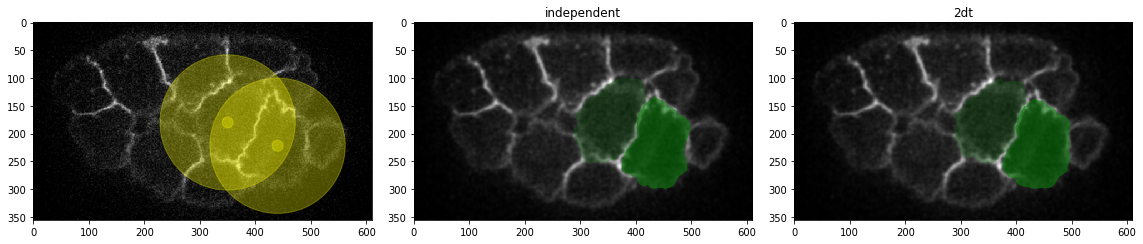

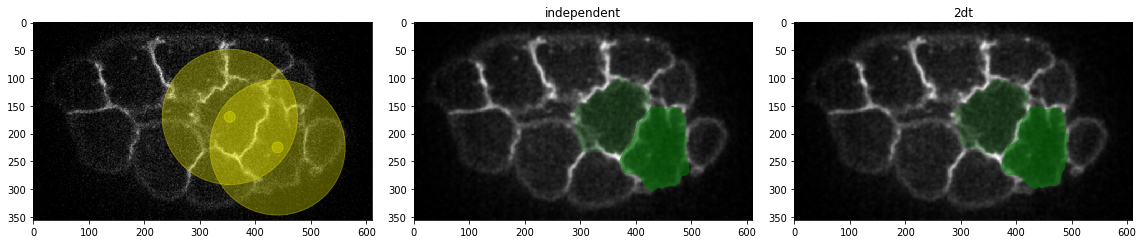

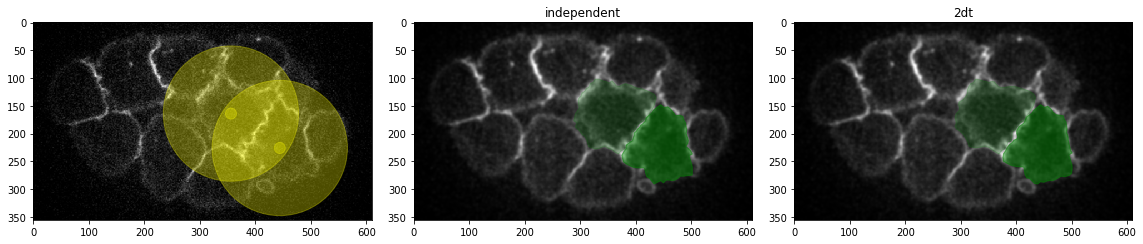

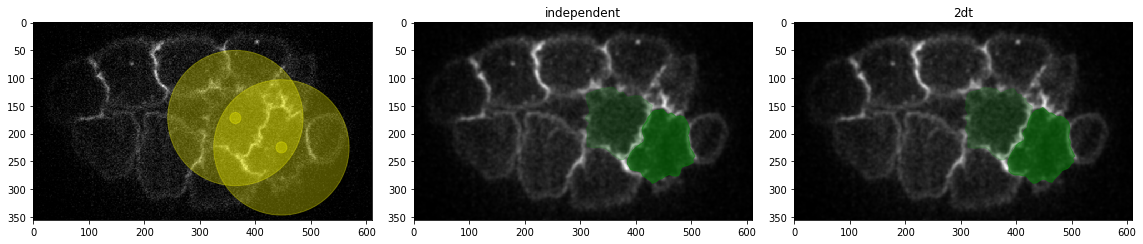

In [10]:
pylab.rcParams['figure.figsize'] = (16, 10)
for frame in range(1,len(data.images),int(len(data.images)/5)):
    fig = plt.figure()
    ax = plt.subplot(131)
    data.plot_minmax( frame, ax, segchannel )
    ax = plt.subplot(132)
    ax.set_title('independent')
    data.plot_result( frame, ax, segchannel_smooth )    
    ax = plt.subplot(133)
    ax.set_title('2dt')
    data.plot_2dt_result( frame, ax, segchannel_smooth )
    fig.tight_layout()

# Flow computation

In [11]:
flows = bsu.compute_flow( flowchannel )
flow_x, flow_y = bsu.split_flow_components( flows )

........................................................................... ...done!


In [12]:
avg_flow_x = bsu.flow_average(flow_x, 5)
avg_flow_y = bsu.flow_average(flow_y, 5)
total_avg_flow_x = np.average(flow_x, axis=0)
total_avg_flow_y = np.average(flow_y, axis=0)

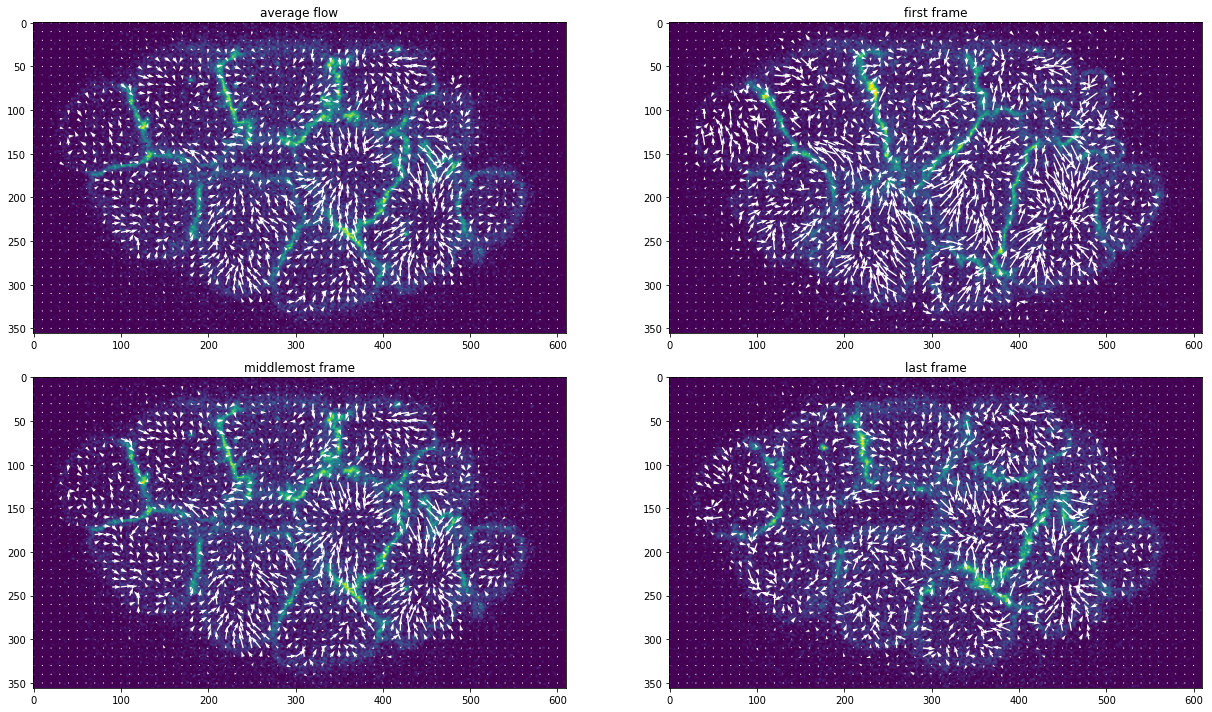

In [13]:
pylab.rcParams['figure.figsize'] = (18, 10)
fig = plt.figure()

y,x = np.mgrid[0:shape(segchannel)[1]:1, 0:shape(segchannel)[2]:1]
skip = (slice(None, None, 10), slice(None, None, 10))

ax = plt.subplot(221)
ax.set_title('average flow')
ax.imshow(segchannel[int(len(flowchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],total_avg_flow_x[skip],-total_avg_flow_y[skip], color='w', scale=50)

ax = plt.subplot(222)
ax.set_title('first frame')
ax.imshow(segchannel[0])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[0][skip],-avg_flow_y[0][skip], color='w', scale=50)

ax = plt.subplot(223)
ax.set_title('middlemost frame')
ax.imshow(segchannel[int(len(flowchannel)/2)])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[int(len(flowchannel)/2)][skip],-avg_flow_y[int(len(flowchannel)/2)][skip], color='w', scale=50)

ax = plt.subplot(224)
ax.set_title('last frame')
ax.imshow(segchannel[-1])#, plt.get_cmap('gray'))
ax.quiver(x[skip],y[skip],avg_flow_x[-1][skip],-avg_flow_y[-1][skip], color='w', scale=50)

fig.tight_layout()
fig.savefig('test.pdf',dpi=300)

# Flow data crunching...

In [14]:
annulus_outer_factor = .85
annulus_inner_factor = .6

In [15]:
membrane_polygones_per_object = []
annulus_outer_polygones_per_object = []
annulus_middle_polygones_per_object = []
annulus_inner_polygones_per_object = []
for obj in objects:
    membrane_polygones = []
    annulus_outer_polygones = []
    annulus_middle_polygones = []
    annulus_inner_polygones = []
    for t in range(T):
        membrane_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,1.0) )
        annulus_outer_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_outer_factor) )
        annulus_middle_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,(annulus_outer_factor+annulus_inner_factor)/2) )
        annulus_inner_polygones.append( data.netsurf2dt[obj].get_polygone_points(t,annulus_inner_factor) )
    membrane_polygones_per_object.append(membrane_polygones)
    annulus_outer_polygones_per_object.append(annulus_outer_polygones)
    annulus_middle_polygones_per_object.append(annulus_middle_polygones)
    annulus_inner_polygones_per_object.append(annulus_inner_polygones)

In [16]:
def get_annulus_bresenham_lines(inner_polygone, outer_polygone):
    annulus_bresenham_lines = []
    for i in range(len(inner_polygone)):
        points = bham.bresenhamline( np.array([inner_polygone[i]]),np.array([outer_polygone[i]]) )
        annulus_bresenham_lines.append(points)
    return annulus_bresenham_lines

In [17]:
annulus_bresenham_lines_per_frame_per_object = []
for obj in objects:
    annulus_bresenham_lines_per_frame = []
    for t in range(T):
        annulus_bresenham_lines = get_annulus_bresenham_lines( annulus_inner_polygones_per_object[obj][t], annulus_outer_polygones_per_object[obj][t] )
        annulus_bresenham_lines_per_frame.append( annulus_bresenham_lines )
    annulus_bresenham_lines_per_frame_per_object.append( annulus_bresenham_lines_per_frame )

### compute membrane movement vectors

In [18]:
membrane_movement_vectors_per_frame_per_object = []
for obj in objects:
    membrane_movement_vectors_per_frame = []
    for t in range(T-1):
        membrane_movement_vectors = []
        poly_t1 = membrane_polygones_per_object[obj][t]
        poly_t2 = membrane_polygones_per_object[obj][t+1]
        for i in range(len(poly_t1)):
            p1 = [poly_t1[i][0] , poly_t1[i][1]]
            p2 = [poly_t2[i][0] , poly_t2[i][1]]
            membrane_movement_vectors.append( [p2[0]-p1[0] , p2[1]-p1[1]] )
        membrane_movement_vectors_per_frame.append( membrane_movement_vectors )
    membrane_movement_vectors_per_frame_per_object.append( membrane_movement_vectors_per_frame )

### compute averaged flow vectors

In [19]:
annulus_avg_flow_vectors_per_frame_per_object = []
for obj in objects:
    annulus_avg_flow_vectors_per_frame = []
    for t in range(T):
        annulus_avg_flow_vectors = []
        lines = annulus_bresenham_lines_per_frame_per_object[obj][t]
        for l, line in enumerate(lines):
            sum_x = 0.0
            sum_y = 0.0
            for point in line:
                sum_x += avg_flow_x[t,point[1],point[0]]
                sum_y += avg_flow_y[t,point[1],point[0]]
            avg_x = sum_x / len(line)
            avg_y = sum_y / len(line)
            annulus_avg_flow_vectors.append([avg_x,avg_y])
        annulus_avg_flow_vectors_per_frame.append(annulus_avg_flow_vectors)
    annulus_avg_flow_vectors_per_frame_per_object.append( annulus_avg_flow_vectors_per_frame )

### compute projected vector lengths

In [20]:
column_vectors = data.netsurfs[0][0].col_vectors # they are normalized to length 1

In [21]:
projected_avg_flows_per_frame_per_object = []
projected_mem_vecs_per_frame_per_object = []
for obj in objects:
    projected_avg_flows_per_frame = []
    projected_mem_vecs_per_frame = []
    for t in range(T-1):
        projected_avg_flows = []
        projected_mem_vecs = []
        for i in range(len(column_vectors)):
            projected_avg_flows.append( bsu.get_projected_length(annulus_avg_flow_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
            projected_mem_vecs.append( bsu.get_projected_length(membrane_movement_vectors_per_frame_per_object[obj][t][i] ,column_vectors[i]) )
        projected_avg_flows_per_frame.append( projected_avg_flows )
        projected_mem_vecs_per_frame.append( projected_mem_vecs )
    projected_avg_flows_per_frame_per_object.append( projected_avg_flows_per_frame )
    projected_mem_vecs_per_frame_per_object.append( projected_mem_vecs_per_frame )

### compute frame averages and correlations for lineplots

In [22]:
avg_membrane_contraction_per_frame_per_object = []
avg_center_flow_per_frame_per_object = []
correlation_per_frame_per_object = []
for obj in objects:
    avg_membrane_contraction_per_frame = []
    avg_center_flow_per_frame = []
    correlation_per_frame = []
    for t in range(T-1):
        memveclengths=projected_mem_vecs_per_frame_per_object[obj][t]
        flowveclengths=projected_avg_flows_per_frame_per_object[obj][t]
        
        avg_membrane_contraction_per_frame.append( np.mean(memveclengths) )
        avg_center_flow_per_frame.append( np.mean( flowveclengths) )
        correlation_per_frame.append( pearsonr(memveclengths, flowveclengths)[0] )
        
    avg_membrane_contraction_per_frame_per_object.append( avg_membrane_contraction_per_frame )
    avg_center_flow_per_frame_per_object.append( avg_center_flow_per_frame )
    correlation_per_frame_per_object.append( correlation_per_frame )

In [23]:
print((correlation_per_frame_per_object[0]))

[-0.058542895092945295, 0.52552916955819562, 0.50900689276201683, 0.51151568492238086, 0.46407524516621496, 0.19938263403193121, 0.29257244088963641, -0.084912856901074973, 0.039108019451108499, 0.19169445326208953, 0.36510494519255726, 0.45949257062647941, 0.38017835642184045, 0.0081025036508809069, 0.25199889124565988, 0.25128679010517913, 0.22581402985746823, 0.091530036737091078, -0.095016326462693132, -0.1815268828034646, -0.15610489142979073, -0.14619482465889369, -0.14709209082519009, 0.38994569530886264, 0.19375353159343431, 0.263746765877168, 0.49974949016353748, 0.12359913238946077, 0.5641511028300884, 0.081963292632879103, 0.46369165526957423, 0.53180119081001409, 0.35490754855910744, 0.20470369205040512, 0.078586245798027282, 0.25860031585069559, -0.11022824448355587, -0.38892089596059742, -0.18182803728932603, -0.2538658912722212, -0.30015902664022964, -0.33306694475759008, -0.13800105350842293, -0.093853673119544387, -0.1545781556831958, -0.25550731205789512, -0.365258045

# Plotting crunched flow data

In [24]:
def plot_coords(ax, poly, c, style='.-', alpha=.5):
    x, y = poly.xy
    ax.plot(x, y, style, color=c, alpha=alpha, zorder=1)

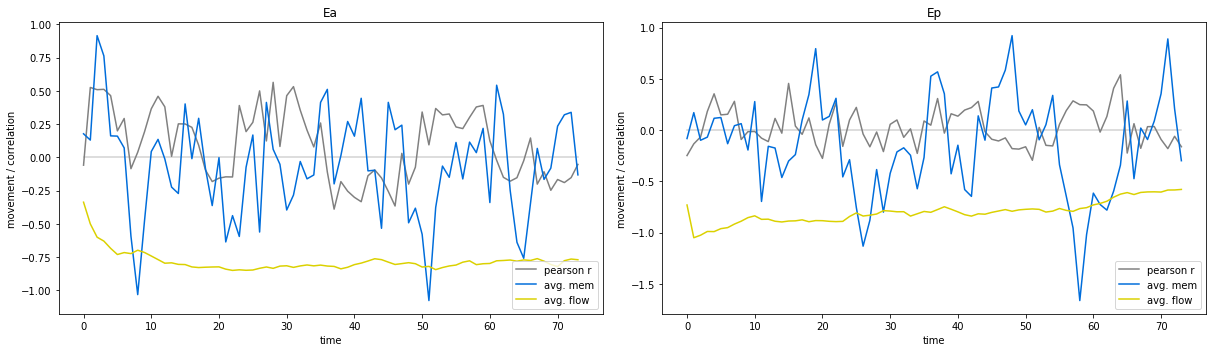

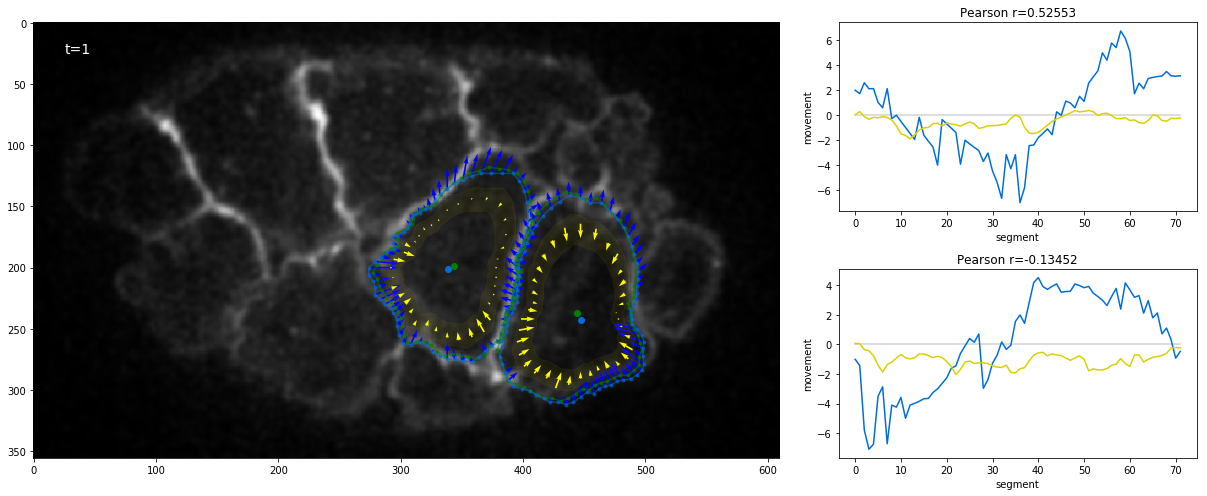

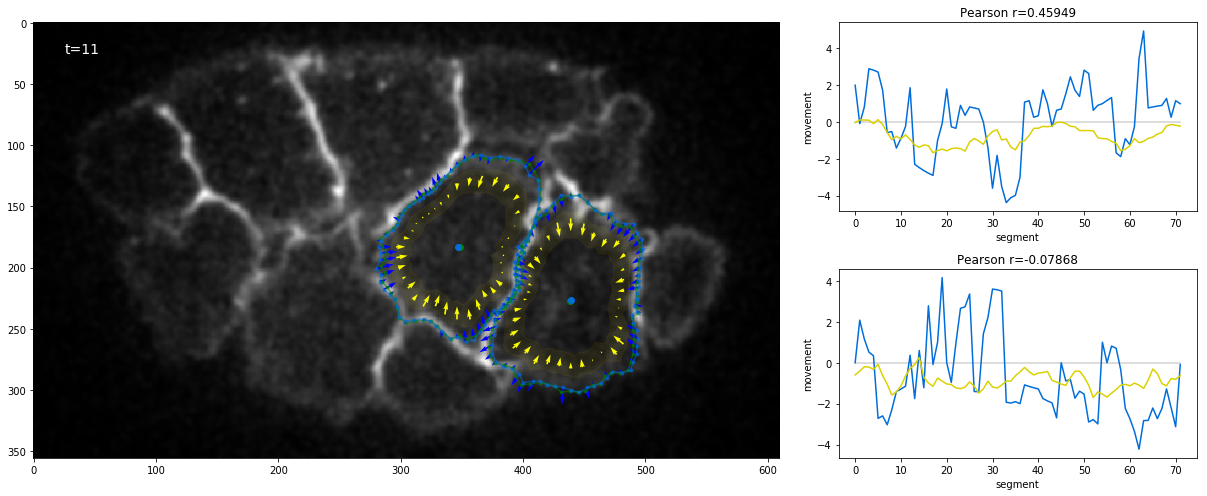

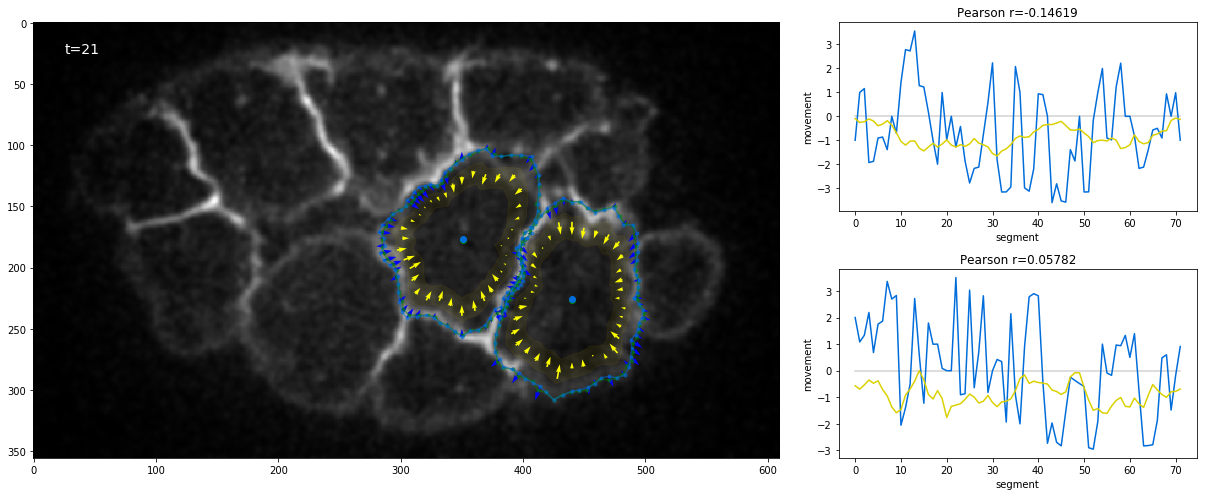

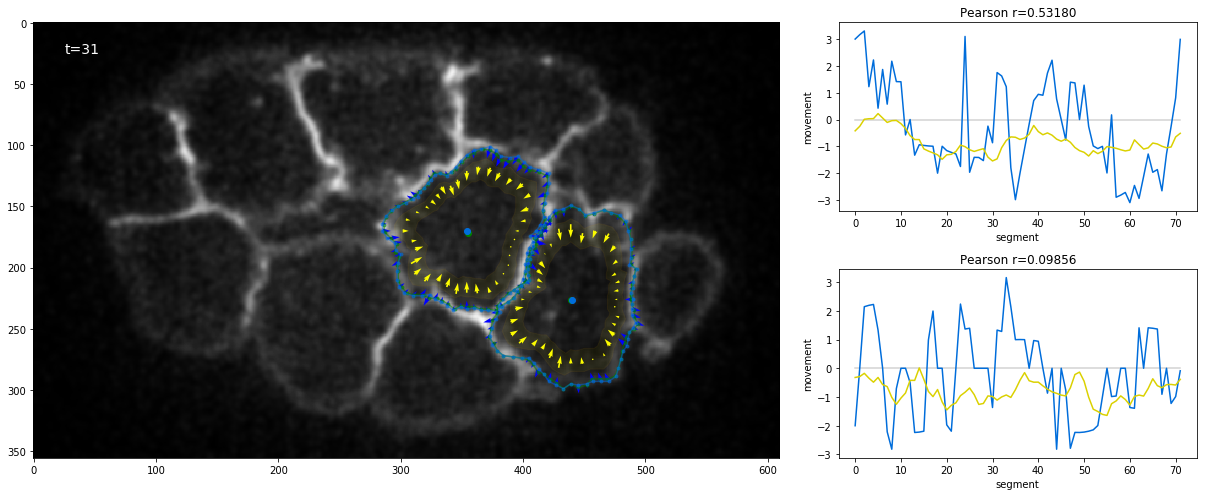

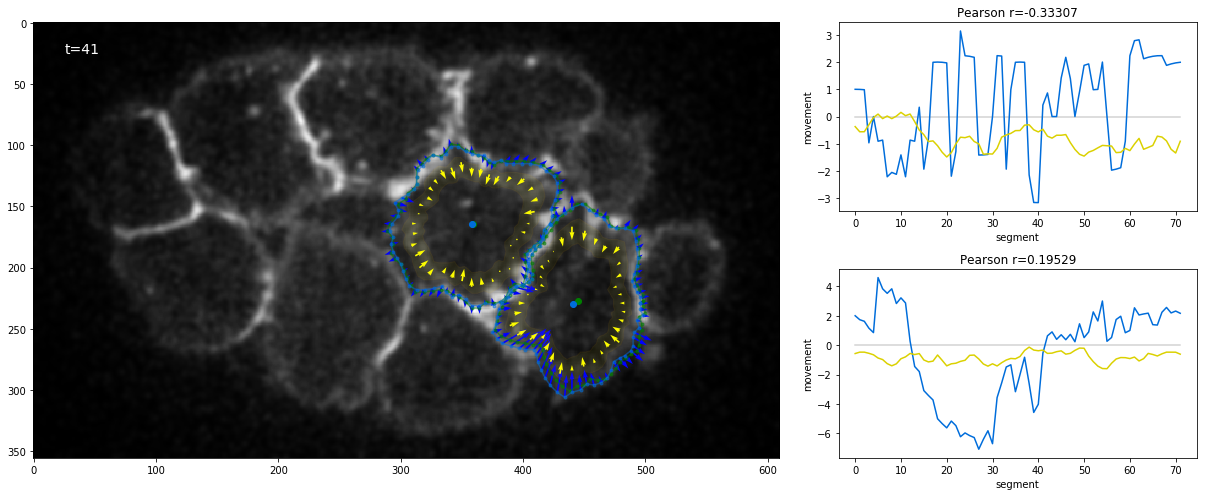

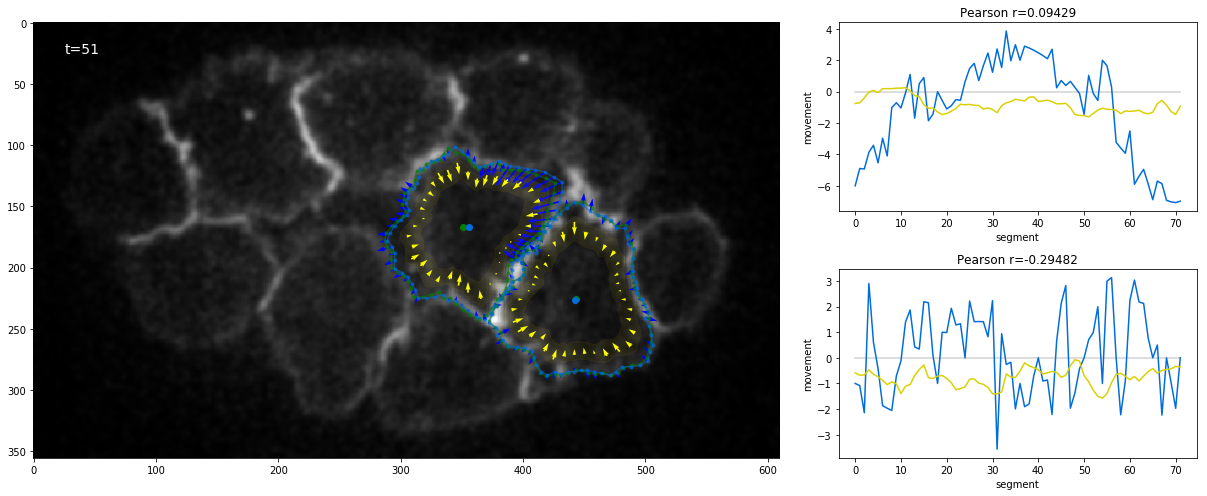

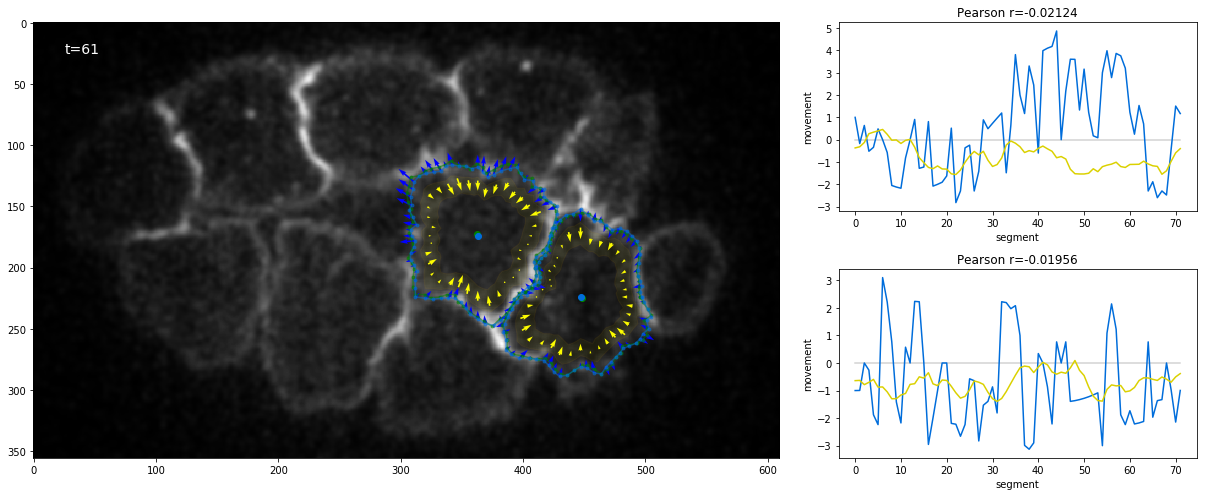

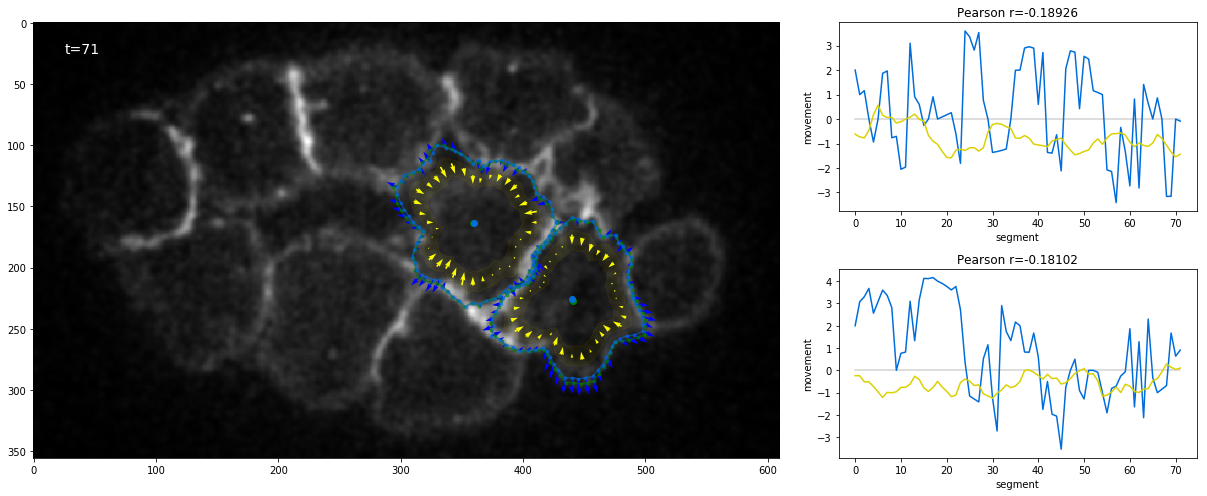

In [25]:
pylab.rcParams['figure.figsize'] = (17, 5)
fig = plt.figure()
ax = plt.subplot(121)
ax.set_title(data.object_names[0])
ax.set_xlabel('time')
ax.set_ylabel('movement / correlation')
ax.plot(np.zeros_like(correlation_per_frame_per_object[0]), color='lightgray')
ax.plot(correlation_per_frame_per_object[0], color='gray', label='pearson r')
ax.plot(avg_membrane_contraction_per_frame_per_object[0], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[0], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
ax = plt.subplot(122)
ax.set_title(data.object_names[1])
ax.set_xlabel('time')
ax.set_ylabel('movement / correlation')
ax.plot(np.zeros_like(correlation_per_frame_per_object[1]), color='lightgray')
ax.plot(correlation_per_frame_per_object[1], color='gray', label='pearson r')
ax.plot(avg_membrane_contraction_per_frame_per_object[1], color='#%02x%02x%02x'%(0,109,219), label='avg. mem')
ax.plot(avg_center_flow_per_frame_per_object[1], color='#%02x%02x%02x'%(219,209,0), label='avg. flow')
ax.legend( loc='lower right')
fig.tight_layout()

pylab.rcParams['figure.figsize'] = (17, 7)
offset = 0
stepsize = 2
show_projected = True

for t in range(1,len(flowchannel),10):
    fig = plt.figure()
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax2 = plt.subplot(233)
    ax3 = plt.subplot(236)

    ax.imshow(segchannel_smooth[t], plt.get_cmap('gray'))
    ax.text(25, 25, 't=%d'%t, fontsize=14, color='w')

    for obj in objects:
        # center points
        ax.plot(data.object_seedpoints[obj][t+1][0],data.object_seedpoints[obj][t+1][1], 'o', color='green')
        ax.plot(data.object_seedpoints[obj][t][0],data.object_seedpoints[obj][t][1], 'o', color='#%02x%02x%02x'%(0,109,219))
        
        # polygones (membrane and annulus)
        poly_membrane = geometry.Polygon(membrane_polygones_per_object[obj][t])
        poly_membrane_t2 = geometry.Polygon(membrane_polygones_per_object[obj][t+1])
        poly_annulus = geometry.Polygon(annulus_outer_polygones_per_object[obj][t], [annulus_inner_polygones_per_object[obj][t][::-1]])
        poly_annulus_middle = geometry.Polygon(annulus_middle_polygones_per_object[obj][t])

        plot_coords( ax, poly_membrane_t2.exterior, 'green', alpha=.5 )
        plot_coords( ax, poly_membrane.exterior, '#%02x%02x%02x'%(0,109,219) )

        patch_annulus = PolygonPatch(poly_annulus, facecolor='#%02x%02x%02x'%(219,209,0), edgecolor='orange', alpha=0.0625, zorder=2)
        ax.add_patch(patch_annulus)

        # membrane quivers
        mem_base_x = [p[0] for p in membrane_polygones_per_object[obj][t]]
        mem_base_y = [p[1] for p in membrane_polygones_per_object[obj][t]]
        if (show_projected):
            mem_vec = [column_vectors[i]*projected_mem_vecs_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            mem_vec_x = [v[0] for v in mem_vec]
            mem_vec_y = [-v[1] for v in mem_vec]
        else:
            mem_vec_x = [v[0] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
            mem_vec_y = [-v[1] for v in membrane_movement_vectors_per_frame_per_object[obj][t]]
        ax.quiver(mem_base_x, 
                  mem_base_y, 
                  mem_vec_x, 
                  mem_vec_y, 
                  width=0.0022, scale=flowchannel.shape[1]/2., color='blue')
        
        # flow quivers
        flow_base_x = [p[0] for p in annulus_middle_polygones_per_object[obj][t]]
        flow_base_y = [p[1] for p in annulus_middle_polygones_per_object[obj][t]]
        if (show_projected):
            flow_vec = [column_vectors[i]*projected_avg_flows_per_frame_per_object[obj][t][i] for i in range(len(column_vectors))]
            flow_vec_x = [v[0] for v in flow_vec]
            flow_vec_y = [-v[1] for v in flow_vec]
        else:
            flow_vec_x = [v[0] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
            flow_vec_y = [-v[1] for v in annulus_avg_flow_vectors_per_frame_per_object[obj][t]]
        ax.quiver(flow_base_x[offset::stepsize], 
                  flow_base_y[offset::stepsize], 
                  flow_vec_x[offset::stepsize], 
                  flow_vec_y[offset::stepsize], 
                  pivot='mid', width=0.0022, scale=flowchannel.shape[1]/4., color='yellow')
        
    # LINEPLOT
    # ========
    ax2.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[0][t])
    ax2.set_xlabel('segment')
    ax2.set_ylabel('movement')
    ax2.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[0][t]), color='lightgray')
    ax2.plot(projected_mem_vecs_per_frame_per_object[0][t], color='#%02x%02x%02x'%(0,109,219))
    ax2.plot(projected_avg_flows_per_frame_per_object[0][t], color='#%02x%02x%02x'%(219,209,0))

    ax3.set_title('Pearson r=%.5f'%correlation_per_frame_per_object[1][t])
    ax3.set_xlabel('segment')
    ax3.set_ylabel('movement')
    ax3.plot(np.zeros_like(projected_mem_vecs_per_frame_per_object[1][t]), color='lightgray')
    ax3.plot(projected_mem_vecs_per_frame_per_object[1][t], color='#%02x%02x%02x'%(0,109,219))
    ax3.plot(projected_avg_flows_per_frame_per_object[1][t], color='#%02x%02x%02x'%(219,209,0))

    fig.tight_layout()